In [1]:
import pandas as pd
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import poisson, norm, chi2
from scipy.special import gamma, factorial
from scipy.optimize import fsolve, root, brentq
import seaborn as sns


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
   "figure.figsize" : (6,5)})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

<h3>Step 1 - Build likelihood function:</h3>
The simplest Likelihood function (without considering nuisance parameters) is given by:

$$ L(\mu) = \frac{(\mu s + b)^{n}}{n!}e^{-(\mu s + b)} $$


In [2]:
def likelihood(n:list, nb:float, ns:float, mu:list) -> list:
    '''
    Obtain the Likelihood for a specific set of data
    n : # observed of events (numpy array)
    nb : # of background events
    ns : # of signal events
    mu : strength parameter (numpy array)
    '''
    ntot = nb + mu*ns
    prob = poisson.pmf(n, ntot)
    
    return prob

def muHat(n:list, nb:float, ns:float):
    '''
    Obtain the value of mu that maximizes the likelihood function
    '''
    
    muHat = (n - nb)/ns
    
    return muHat

def likelihoodRatio(n:list, nb:float, ns:float, mu:list) -> list:
    
    L = likelihood(n, nb, ns, mu)
    Lmax = likelihood(n, nb, ns, muHat(n, nb, ns))
    
    return L/Lmax

def qtest(n:list, nb:float, ns:float, allowNegativeMu=False) -> list:
    
    mu = np.array([1.]*len(n))
    
    if not allowNegativeMu:
        q = np.where(muHat(n, nb, ns)>0, -2.*np.log(likelihoodRatio(n, nb, ns, mu)), 0.)
        
    else:
        q = -2.*np.log(likelihoodRatio(n, nb, ns, mu))
        
    return q

def genData(mu:float, nb:float, ns:float, nsim:int) -> list:
    '''
    Generates pseudo data that follows a poissonian distribution.
    '''
    
    ngen = np.random.poisson(lam=mu*ns+nb, size=nsim) 
    return ngen


In [3]:
# Set known values
ns = 14.933117
nb = 38.836
mu = 1.
nobs = 40.
nsim = int(1e7)

pseudoN = genData(mu, nb, ns, nsim)

In [4]:
# Test under the s + b hypothesis
negativeMu = True
q0 = qtest(pseudoN, nb, ns, negativeMu)
negativeMu = False
q0B = qtest(pseudoN, nb, ns, negativeMu)

In [5]:
qobs = qtest(np.array([nobs]), nb, ns)
qvals = np.linspace(q0.min(), q0.max(), 100)

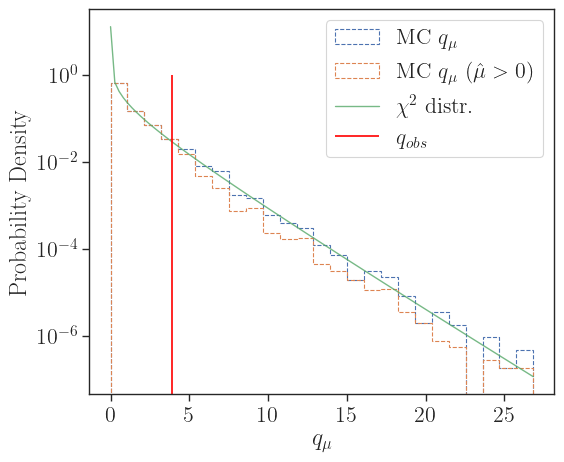

In [6]:
# Plot histogram
hist = plt.hist(q0, bins=25, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu}$')
histB = plt.hist(q0B, bins=25, density=True, linestyle='--', histtype='step', label=r'MC $q_{\mu}$ $(\hat{\mu}>0)$')
plt.plot(qvals, chi2.pdf(qvals, df=1), linewidth=1, alpha=0.8, label=r'$\chi^{2}$ distr.')
plt.vlines(qobs, 0, 1, color='red', label=r'$q_{obs}$')

plt.legend()
plt.ylabel('Probability Density')
plt.xlabel(r'$q_{\mu}$')
plt.yscale('log')
plt.show()

In [7]:
# p-value from histogram
pval_mc = len(q0[q0>=qobs])/len(q0)
pval_mcB = len(q0B[q0B>=qobs])/len(q0)

# p-value from chisquared distr.
pval_chi = 1 - chi2.cdf(qobs, 1)

print(r'p-value following MC method:', pval_mc)
print(r'p-value following MC method (mu>0):', pval_mcB)
print('p-value from chi squared distribution:', float(pval_chi))

p-value following MC method: 0.0566173
p-value following MC method (mu>0): 0.0416057
p-value from chi squared distribution: 0.04907900657964037


<h3>Step 2 - Find $\mu^{95\%}$</h3>
We try to find the value of $\mu$ that excludes the hypothesis at a 95% confidence level

In [8]:
cl = .95 # Confidence level
alpha = 1 - cl # Type 1 error

In [9]:
# Using chi squared method:
cdf = lambda t: 1 - chi2.cdf(t, 1) - alpha
t95 = root(cdf, 0).x

t_func = lambda mu: -2.*np.log(likelihoodRatio(nobs, nb, ns, mu)) - t95
mu95 = float(root(t_func, 1).x)
print(mu95)

0.9959151277832176


Let us now test different values of b:

In [10]:
s = 33.9
bList = [725., 299.9, 148.7, 69.7, 34.5, 32.3]
nobsList = [721., 298., 146., 65., 39., 35.]
mu = 1.
nsim = int(1e6)

In [11]:
qList, qobsList = [], []
for i, b in enumerate(bList):
    qList.append(qtest(genData(mu, b, s, nsim), b, s, True))
    qobsList.append(qtest(np.full(nsim, nobsList[i]), b, s, True)[1])

In [12]:
pList = []
for i, q in enumerate(qList):
    pList.append(len(q[q>=qobsList[i]])/len(qList[i]))

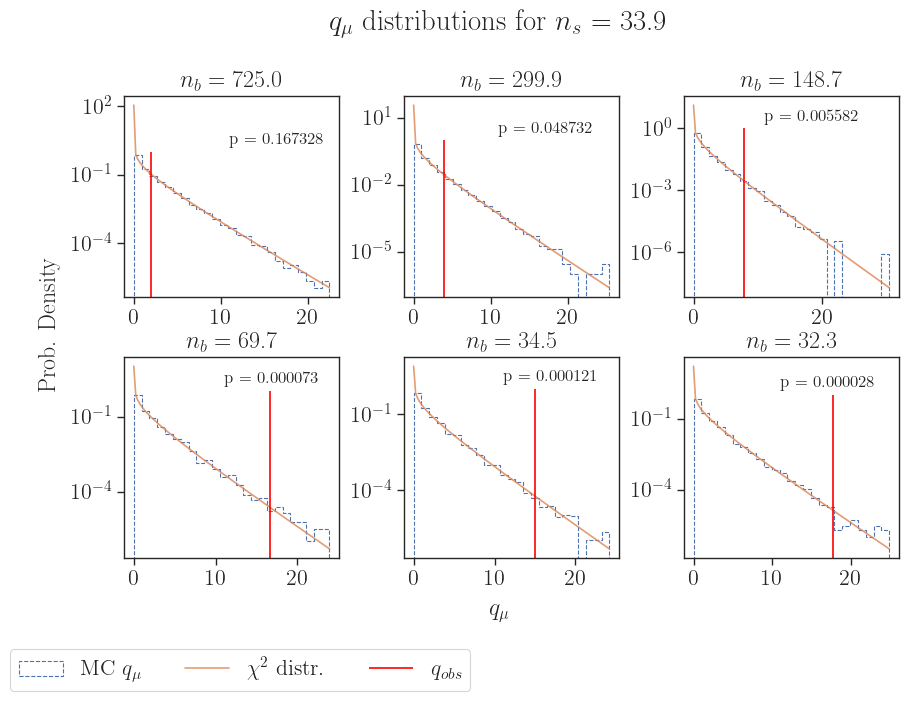

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,6))
ax = ax.flatten()

for i, a in enumerate(ax):
    a.hist(qList[i], bins=25, density=True, histtype='step', linestyle='--')
    a.plot(np.linspace(qList[i].min(), qList[i].max(), 100), 
             chi2.pdf(np.linspace(qList[i].min(), qList[i].max(), 100), df=1), 
             alpha=0.8)
    a.vlines(qobsList[i], 0, 1, 'red')
    
    a.text(11, 2, r'p = %f' %pList[i], fontsize='x-small')
    a.set_yscale('log')
    
    a.set_title(r'$n_{b}=$ %1.1f' %bList[i])
    

labels = [r'MC $q_{\mu}$', r'$\chi^{2}$ distr.', r'$q_{obs}$']

fig.legend(labels, loc='lower left', bbox_to_anchor=(0,-0.13), ncol=len(labels), bbox_transform=fig.transFigure)
fig.text(0.5, 1, r'$q_{\mu}$ distributions for $n_{s}$ = %1.1f' %s, ha='center', va='center', fontsize='large') # title
fig.text(0.5, 0.02, r'$q_{\mu}$', ha='center', va='center') # x label
fig.text(0.05, 0.5, 'Prob. Density', ha='center', va='center', rotation='vertical') # y label
fig.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()

<h3>Step 3 - Modified Frequentist Approach:</h3>
The quantity $CL_{s}$ is introduced as:
$$ CL_{s} = \frac{p_{s+b}}{1 - p_{b}}, $$
where $p_{s+b}$ is the p-value under the signal plus background hypothesis, and $p_{b}$ is the p-value for the background hypothesis. The upper limit is given by $CL_{s} \leq \alpha$.

In [14]:
cl = .95 # Confidence level
alpha = 1 - cl # Type 1 error

pseudoNb = genData(0., nb, ns, nsim)
muB = np.zeros(len(pseudoNb)) # value for mu under the b-only hypothesis is zero
qB = -2.*np.log(likelihoodRatio(pseudoNb, nb, ns, muB))

pSB = pval_mcB
pB = len(qB[qB >= qobs])/len(qB)

print(r'p-value for b-only following MC method:', pB)
print(r'p-value for s+b following MC method (mu>0):', pval_mcB)

p-value for b-only following MC method: 0.054228
p-value for s+b following MC method (mu>0): 0.0416057


In [15]:
CLs = pSB/(1 - pB)
print(CLs)

0.04399125793531634


In [16]:
Psb1 = len(pseudoN[pseudoN <= nobs])/len(pseudoN)
Pb1 = len(pseudoNb[pseudoNb <= nobs])/len(pseudoNb)
print(Psb1, Pb1)

0.0308749 0.613862


In [17]:
CLs1 = Psb1/Pb1
CLs1

0.05029615776835836